<a href="https://colab.research.google.com/github/sp7412/digital-signal-processing-lecture/blob/master/Waterfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
from mpl_toolkits.mplot3d import Axes3D

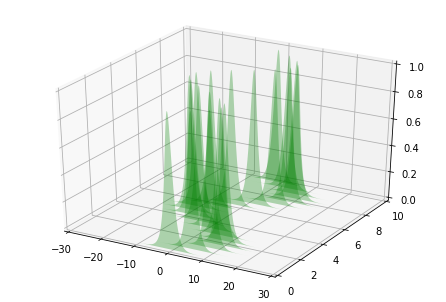

In [3]:
T = 60.
n = 512
t = np.linspace(-T/2., T/2., n+1)
t = t[0:n]
# There's a function to set up the frequencies, but doing it by hand seems to help me think 
# things through.
k = np.array([(2. * np.pi)*i if i < n/2 else (2. * np.pi) * (i - n) 
  for i in range(n)])

ks = np.fft.fftshift(k)
slc = np.arange(0, 10, 0.5)
# I haven't quite figured out how to use the meshgrid function in numpy
T, S = np.meshgrid(t, slc)
K, S = np.meshgrid(k, slc)

# Now, we have a plane flying back and forth in a sine wave and getting painted by a radar pulse
# which is a hyperbolic secant (1/cosh)
U = 1./np.cosh(T - 10. * np.sin(S)) * np.exp(1j * 0. * T)

def waterfall(X, Y, Z, nslices):

  # Function to generate formats for facecolors
  cc = lambda arg: colorConverter.to_rgba(arg, alpha=0.3)
  # This is just wrong. There must be some way to use the meshgrid or why bother.
  verts = []
  for i in range(nslices):
    verts.append(list(zip(X[i], Z[i])))

  xmin = np.floor(np.min(X))
  xmax = np.ceil(np.max(X))
  ymin = np.floor(np.min(Y))
  ymax = np.ceil(np.max(Y))
  zmin = np.floor(np.min(Z.real))
  zmax = np.ceil(np.max(np.abs(Z)))

  fig=plt.figure()
  ax = Axes3D(fig)
 
  poly = PolyCollection(verts, facecolors=[cc('g')])
  ax.add_collection3d(poly, zs=slc, zdir='y')
  ax.set_xlim(xmin,xmax)
  ax.set_ylim(ymin,ymax)
  ax.set_zlim(zmin,zmax)
  plt.show()

waterfall(T, S, U.real, len(slc))

In [4]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
'' Title: Title: ADDITIVE AND MULTIPLICATIVE SCRAMBLING
'' Author: Filippo Valmori
'' Date: 16/11/2018
'' Reference: [1] Wikipedia - https://en.wikipedia.org/wiki/Scrambler	
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


### PARAMETERS ###

NcA = 15                                                    # Number of additive LFSR cells
ConVectA = (0,0,0,0,0,0,0,0,0,0,0,0,0,1,1)                  # Connection vector of additive LFSRs, i.e. (1+)z^-14+z^-15 - DVB standard
InitStA = [1,0,0,1,0,1,0,1,0,0,0,0,0,0,0];					# Initial state of additive LFSRs

NcM = 17;												    # Number of multiplicative LFSR cells
ConVectM = (0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1); 			# Connection vector of multiplicative LFSRs, i.e. (1+)z^-12+z^-17
InitStM = [0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0];				# Initial state of multiplicative LFSRs



### SCRAMBLING FUNCTIONS ###

'''
'' Function for implementing an additive scrambler (aka synchronous or
'' linear-feedback shift register scrambler) and descrambler.
'''
def AddScramb( InBytes, ConVect, InitState ) :
    InBits = Byte2BitConv(InBytes)
    BitLen = len(InBits)
    RegState = InitState[:]
    OutBits = [0]*BitLen
    for j in range(BitLen) :
        RegBit = (sum([v1*v2 for v1,v2 in zip(RegState,ConVect)])%2)
        OutBits[j] = InBits[j]^RegBit
        RegState[1:] = RegState[:-1]
        RegState[0] = RegBit
    return Bit2ByteConv(OutBits)


'''
'' Function for implementing a multiplicative (aka self-synchronizing) scrambler.
'''
def MultScramb( InBytes, ConVect, InitState ) :
    InBits = Byte2BitConv(InBytes)
    BitLen = len(InBits)
    RegState = InitState[:]
    OutBits = [0]*BitLen
    for j in range(BitLen) :
        RegBit = (sum([v1*v2 for v1,v2 in zip(RegState,ConVect)])%2)
        OutBits[j] = InBits[j]^RegBit
        RegState[1:] = RegState[:-1]
        RegState[0] = OutBits[j]
    return Bit2ByteConv(OutBits)


'''
'' Function for implementing a multiplicative (aka self-synchronizing) descrambler.
'''
def MultDescramb( InBytes, ConVect, InitState ) :
    InBits = Byte2BitConv(InBytes)
    BitLen = len(InBits)
    RegState = InitState[:]
    OutBits = [0]*BitLen
    for j in range(BitLen) :
        RegBit = (sum([v1*v2 for v1,v2 in zip(RegState,ConVect)])%2)
        OutBits[j] = InBits[j]^RegBit
        RegState[1:] = RegState[:-1]
        RegState[0] = InBits[j]
    return Bit2ByteConv(OutBits)


'''
'' Function for converting a byte stream into the corresponding bit stream.
'''
def Byte2BitConv( InBytes ) :
    InLen = len(InBytes)
    OutLen = (InLen<<3)
    OutBits = [0]*OutLen
    for j in range(OutLen) :
        ByteIdx = (j>>3)
        BitIdx = 7-(j%8)
        if (InBytes[ByteIdx] >>BitIdx)%2 :
            OutBits[j] = 1
    return OutBits


'''
'' Function for converting a bit stream into the corresponding byte stream.
'''
def Bit2ByteConv( InBits ) :
    InLen = len(InBits)
    OutLen = (InLen>>3)
    OutBytes = [0]*OutLen
    for j in range(InLen) :
        if InBits[j] :
            ByteIdx = (j>>3)
            BitIdx = 7-(j%8)
            OutBytes[ByteIdx] += (1<<BitIdx)
    return OutBytes



### MAIN FUNCTION ###

InfoLen = 10                                                # Info stream length (in bytes)
InfoBytes = [0]*InfoLen                                     # All-zero info stream generation

ScrambBytesA = AddScramb(InfoBytes,ConVectA,InitStA)        # Apply additive scrambling
DescrambBytesA = AddScramb(ScrambBytesA,ConVectA,InitStA)   # Apply additive descrambling 
print("\n * Additive Scrambling")
print("INF = ",InfoBytes)
print("SCR = ",ScrambBytesA)
print("DES = ",DescrambBytesA)

ScrambBytesM = AddScramb(InfoBytes,ConVectM,InitStM)        # Apply multiplicative scrambling
DescrambBytesM = AddScramb(ScrambBytesM,ConVectM,InitStM)   # Apply multiplicative descrambling
print("\n * Multiplicative Scrambling")
print("INF = ",InfoBytes)
print("SCR = ",ScrambBytesM)
print("DES = ",DescrambBytesM)


 * Additive Scrambling
INF =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SCR =  [3, 246, 8, 52, 48, 184, 163, 147, 201, 104]
DES =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 * Multiplicative Scrambling
INF =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SCR =  [149, 83, 31, 152, 118, 75, 95, 144, 86, 205]
DES =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
